In [1]:
# Import geopandas package
import geopandas as gpd
# Read in shapefile and examine data
contiguous_usa = gpd.read_file('cb_2018_us_state_20m.shp')
contiguous_usa.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


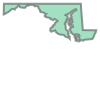

In [2]:
contiguous_usa.iloc[0]['geometry']

In [3]:
str(contiguous_usa.iloc[0]['geometry'])

'MULTIPOLYGON (((-76.04621299999999 38.025533, -76.00733699999999 38.036706, -75.98008899999999 38.004891, -75.98464799999999 37.938121, -76.04652999999999 37.953586, -76.04621299999999 38.025533)), ((-79.48437199999999 39.3443, -79.482366 39.531689, -79.47666199999999 39.721078, -79.3924584050224 39.7214393586401, -79.045576 39.722928, -78.9284161298889 39.7229985874409, -78.80829952962159 39.7230709562769, -78.723578 39.723122, -78.380477064564 39.72270413884, -78.34283351857439 39.7226582929265, -78.34259299999999 39.722658, -78.09897069616669 39.72246619442809, -78.075861 39.722448, -77.76864399999999 39.721538, -77.469274 39.720229, -77.4691450036804 39.72022900225, -77.45943341952389 39.72022917164499, -77.23994999999999 39.720233, -77.21702375523739 39.7202172483854, -76.9993180263332 39.7200676723526, -76.991062 39.720062, -76.7870971997576 39.72104814611129, -76.71577099999999 39.721393, -76.5694491257313 39.7214585707527, -76.41897999999999 39.721526, -76.2396837411146 39.721

In [4]:
import pandas as pd
# Read in state population data and examine
state_pop = pd.read_csv('state_pop_20181.csv')
state_pop.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2018
0,10,0,0,0,United States,327167434
1,20,1,0,0,Northeast Region,56111079
2,20,2,0,0,Midwest Region,68308744
3,20,3,0,0,South Region,124753948
4,20,4,0,0,West Region,77993663


In [5]:
# Merge shapefile with population data
pop_states = contiguous_usa.merge(state_pop, left_on = 'NAME', right_on = 'NAME')
# Drop Alaska and Hawaii
pop_states = pop_states.loc[~pop_states['NAME'].isin(['Alaska', 'Hawaii'])]

In [6]:
import json
from bokeh.plotting import figure, output_file, show,save, ColumnDataSource
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = pop_states.to_json())

In [7]:
# Create figure object.
p = figure(title = 'Lead Levels in Water Samples, 2018', 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,
                   fill_color = None,
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@NAME'),
                                ('Population','@POPESTIMATE2018')]))
show(p)

In [8]:
# Define color palettes
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40000000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '5000000': '5,000,000',
 '10000000':'10,000,000', '15000000':'15,000,000',
 '20000000':'20,000,000', '25000000':'25,000,000',
 '30000000':'30,000,000', '35000000':'35,000,000',
 '40000000':'40,000,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Lead Levels in Water Samples, 2018', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,
                   fill_color = {'field' :'POPESTIMATE2018',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@NAME'),
                               ('Population', '@POPESTIMATE2018')]))
# Specify layout
# p.add_layout(color_bar, 'below')
show(p)